<a href="https://colab.research.google.com/github/LuuZwide/ProjectOne/blob/PolicyGradient/ZWDE_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Testing Git changes


In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np 
import yfinance as yf
drive.mount('/content/drive')
!cp "/content/drive/MyDrive/Functions/Preprocessing/Precossing_Functions_for_stock_chpters_1.ipynb" .
%run Precossing_Functions_for_stock_chpters_1.ipynb

from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC, LinearSVR, SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, roc_curve, precision_score, recall_score, precision_recall_curve,roc_auc_score
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, MaxAbsScaler

import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras import Model
import tensorflow_probability as tfp
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping 
import tensorflow.keras.backend as K
from keras.activations import elu
from tensorflow.keras.initializers import HeNormal
import math 

Mounted at /content/drive


In [ ]:
stock_dict = {}
stocks = ['IBM']

for stock in stocks:
  ticker = yf.Ticker(stock)
  data = ticker.history(period="Max")
  data = data.drop(['Dividends','Stock Splits'] , axis = 1)
  data.reset_index(drop = False, inplace = True)
  print(stock,'  ', len(data))
  
  prices = data['Close']
  len_of_data = len(prices)
  window_size = 5
  stock_dataset = Combine_dataframes(data ,prices, window_size,len_of_data, fast = 12, slow = 26)
  stock_dataset = stock_dataset.drop('next_close', axis = 1) # the next close price will be calculated with a neural net
  stock_dict[stock] = stock_dataset
  attribs = list(stock_dict[stock].columns)

IBM    15445


In [ ]:
print(attribs)
chart = stock_dict['IBM']
stock_prices = chart['Open']

['Open', 'High', 'Low', 'Close', 'Volume', 'moving_avg', 'exm_avg', 'STOCHk_5_3_3', 'STOCHd_5_3_3', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9']


In [ ]:
data_pipeline = Pipeline(
  (
    ('ConvertDataFrame', DataFrameSelector(attribs)),
    ('Scaler',MinMaxScaler())
  )
)

In [ ]:
chart = data_pipeline.fit_transform(chart)

print(len(chart))
print(chart.shape)
print(chart[1])
print(chart[1][3]) # this is for the closing price

15445
(15445, 12)
[0.00507473 0.00478797 0.00520677 0.0051667  0.00421198 0.
 0.00482823 0.         0.         0.64548494 0.55050507 0.62254381]
0.005166698802658353


In [ ]:
stock_prices[1:10]

1    1.591516
2    1.605429
3    1.587344
4    1.556737
5    1.535869
6    1.549781
7    1.553955
8    1.569257
9    1.574823
Name: Open, dtype: float64

In [ ]:
class Portfolio():
# Currently we won't take the cost of transactions into considerations
  def __init__(self, starting_amount ):
    self.port_value = starting_amount
    self.starting_amount = starting_amount
    self.rate_return = 0
  
  def update_port(self, weights, prev_closing, cur_closing):
    # First we need to update the value of the portfolio
    prev = np.array([1, prev_closing])
    curr = np.array([1, cur_closing])
    relative_vector = curr / prev
    pt = self.port_value * np.dot(relative_vector, weights) 

    self.port_value = pt
    return self.port_value, relative_vector

  def calculate_return(self, relative_vector, weights):
    # Calculate the rate of returns
    self.rate_return = np.dot(relative_vector, weights)
    self.rate_return = math.log(self.rate_return)

    return self.rate_return 
    

In [ ]:
class Env():

  def __init__(self, Portfolio, chart, episode_length ):
    self.chart = chart
    self.portfolio = Portfolio
    self.episode_length = episode_length
    self.index = 0
    self.counter = 0 # Count the number of days the agent have been trading  
    self.done = False
    self.trunc = False 
    self.starting_amount = Portfolio.starting_amount
    self.trade_count = 0 # Number of times the agent has traded
    self.current_portfolio_value = self.portfolio.port_value
    self.returns = 0

  def reset(self): # Index is to deside when to start the trading period

  # The starting index should be a random number between (len(chart) - 250)
    self.portfolio = Portfolio(self.starting_amount)
    self.index = random.randint(0, len(self.chart) - self.episode_length + 1)
    initial_weights = np.array([1, 0])
    self.counter = 0
    self.state = np.concatenate([self.chart[self.index], initial_weights])
    return self.state

  def check_done(self, portfolio_value):
    done = False 
    threshhold =  portfolio_value/self.starting_amount
    if threshhold > 0.98:
      done = False
    else:
      done = True
    return done

  def check_trunc(self):
    if(self.counter > self.episode_length):
      return True
    else:
      return False

  def step(self, action ):
    # State is the current price and states of the asset and the previous action concatenated 
    # The action is weights

    if ((self.index + 1) < len(self.chart)):
      prev_details = self.chart[self.index]
      prev_closing = prev_details[3]

      asset_details = self.chart[self.index + 1] 
      cur_closing = asset_details[3]

      # Update portfolio based on action....
      self.current_portfolio_value, relative_vector = self.portfolio.update_port(action, prev_closing, cur_closing)
      self.returns = self.portfolio.calculate_return(relative_vector, action)
      reward = self.returns
      next_state = np.concatenate([self.chart[self.index + 1], action])
      done = False
      trunc = False  
    
    else:
      # Trunc is true 
      # And the episode will be done
      # Reward for not loosing money
      trunc = True
      next_state = np.concatenate([self.chart[self.index], action])
      done = False
      reward = self.returns + 1

    if(self.check_done(self.current_portfolio_value)) is True:
      done = True
      next_state = np.concatenate([self.chart[self.index], action])
      reward = -10
      trunc = False

    if(self.check_trunc() is True):
      trunc = True
      done = False
      reward = self.returns + 1
      next_state = np.concatenate([self.chart[self.index], action])



    self.counter = self.counter + 1 
    self.next_state =  next_state # Is the next asset details and the action taken at this time step
    self.reward = reward # Is the return from the changed portfolio
    self.done = done # Done being True would mean the portfolio as lost too much value there is a penalty for that 
    self.trunc = trunc # Trunc being True would mean agent has traded for maximum number of days 
    self.index = self.index + 1

    return self.next_state, self.reward, self.done, self.trunc



In [ ]:
class ActorCritic(Model):
  def __init__(self, num_actions, obsv_space, dim_size1 = 128, dim_size2 = 64, dropout_rate = 0.2):
    super(ActorCritic, self).__init__()
    self.num_actions = num_actions
    self.obsv_space = obsv_space 
    self.layer_1 = dim_size1
    self.layer_2 = dim_size2
    initializer = HeNormal(seed = 42)
    self.dropout_rate = dropout_rate
    
    self.dense_layer1 = keras.layers.Dense(62, activation = elu , kernel_initializer = HeNormal)
    #self.dropout_1 = keras.layers.Dropout(self.dropout_rate)
    self.dense_layer2 = keras.layers.Dense(32, activation = elu, kernel_initializer = HeNormal)
    #self.dropout_2 = keras.layers.Dropout(self.dropout_rate)
    self.dense_layer3 = keras.layers.Dense(16, activation = elu, kernel_initializer = HeNormal)
    #self.dropout_3 = keras.layers.Dropout(self.dropout_rate)
    self.dense_layer4 = keras.layers.Dense(4, activation = elu, kernel_initializer = HeNormal)
    #self.dropout_4 = keras.layers.Dropout(self.dropout_rate)
    self.value_function = keras.layers.Dense(1)
    self.policy = keras.layers.Dense(self.num_actions, 'softmax')

  def call(self, state):
    val = self.dense_layer1(state)
    #val = self.dropout_1(val)
    common_1 = self.dense_layer2(val)
    #common_1 = self.dropout_2(common_1)
    common_2 = self.dense_layer3(common_1)
    #common_2 = self.dropout_3(common_2)
    common_3 = self.dense_layer4(common_2)
    #common_3 = self.dropout_4(common_3)
    critic = self.value_function(common_3)
    actor = self.policy(common_3)

    return critic, actor 

In [ ]:
class Agent():

  def __init__(self, num_actions, obsv_space, layer1_size, layer2_size, gamma, learning_rate):
    self.num_actions = num_actions
    self.obsv_space = obsv_space
    self.layer1_size = layer1_size
    self.layer2_size = layer2_size
    self.gamma = gamma
    self.learning_rate = learning_rate

    self.actor_critic = ActorCritic(self.num_actions, self.obsv_space, self.layer1_size, self.layer2_size)
    self.actor_critic.compile(optimizer = keras.optimizers.Adam(learning_rate = self.learning_rate))


  def choose_action(self,state):
    state = tf.convert_to_tensor([state])
    _,weights = self.actor_critic(state)
    action = weights.numpy()[0]
    actual_action = tf.math.argmax(weights, axis=1).numpy()[0]
    return action , actual_action

  def learn(self, obsv, action, reward, next_obsv, done):
    state = tf.convert_to_tensor([obsv], dtype = tf.float32)
    state_ = tf.convert_to_tensor([next_obsv], dtype = tf.float32)
    reward = tf.convert_to_tensor(reward, dtype= tf.float32)
    weights = tf.convert_to_tensor([action],dtype = tf.float32)

    with tf.GradientTape() as tape:
      state_value, probs = self.actor_critic(state)
      next_state_value, _ = self.actor_critic(state_)

      state_value = tf.squeeze(state_value)
      state_value_ = tf.squeeze(next_state_value)

      action_probs = tfp.distributions.Categorical(probs = probs)
      log_probs = action_probs.log_prob(weights)

      delta = reward + state_value_ * self.gamma * (1 - int(done)) - state_value
      actor_loss = -log_probs * delta
      critic_loss = delta ** 2
      total_loss = actor_loss + critic_loss

    gradients = tape.gradient(total_loss, self.actor_critic.trainable_variables)
    self.actor_critic.optimizer.apply_gradients(zip(gradients, self.actor_critic.trainable_variables))
    return total_loss

In [ ]:
episode_length = 365
starting_amount = 1000
portfolio =  Portfolio(starting_amount )
chart = chart
action_size = 2 # We are dealing with 1 stock and the cash 
state_size = chart.shape[1] + action_size
layer_size1 = 1024
layer_size2 = 512
learning_rate = 1e-5
num_episodes = 30000
gamma = 0.99

env = Env(portfolio, chart, episode_length)
agent = Agent(num_actions = action_size, obsv_space = state_size, layer1_size = layer_size1, 
              layer2_size = layer_size2, gamma = gamma, learning_rate = learning_rate )

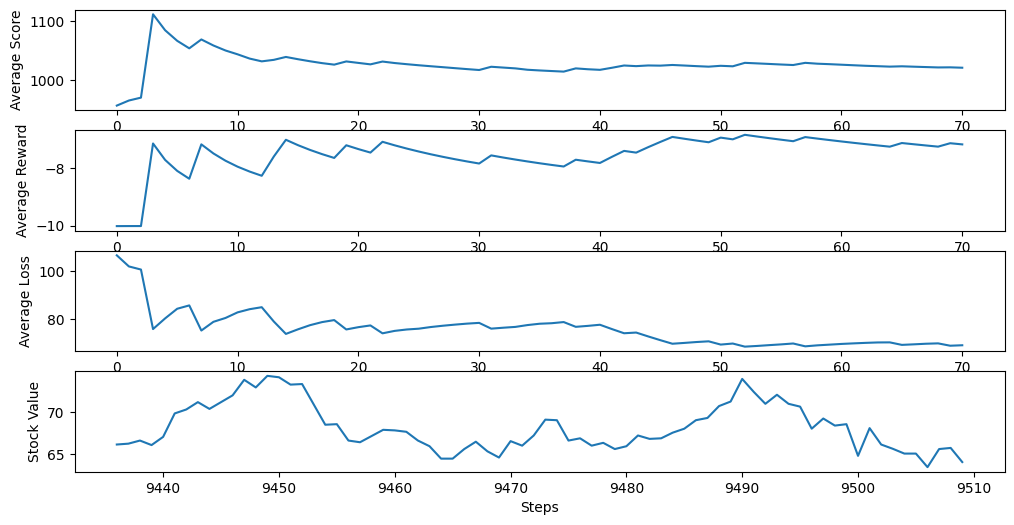

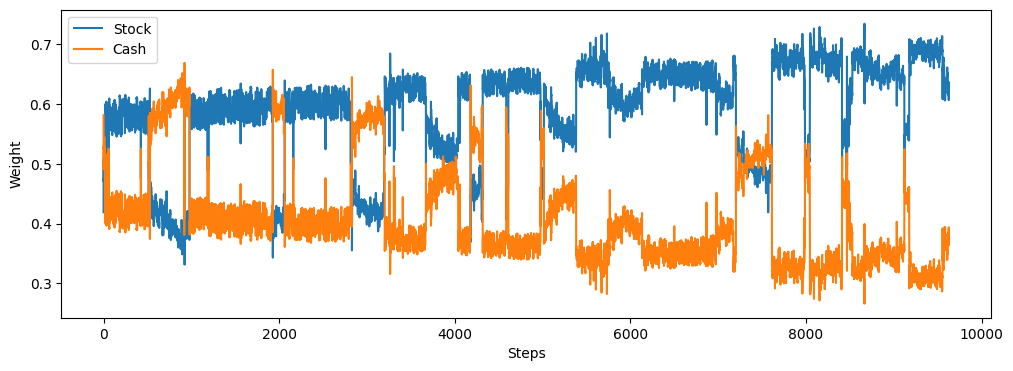

final port value:  965.0615489808002
trunc: 1647.4610742810225
final port value:  979.6862033063494
final port value:  977.7106743433022


KeyboardInterrupt: ignored

In [ ]:
from IPython.core.display import clear_output
avg_scores = []
avg_rewards = []
scores = 0
rewards = 0
score_history = []
reward_history = []
loss_history = []
loss = 0
avg_lesses = []


buy_counts = [] 
cash_counts = [] 
stock_values = []
weights_history = []
starting_indices = []

for e in range(num_episodes):
    state = env.reset()
    scores = 0
    rewards = 0
    done, trunc = (False, False)
    buy_count = 0
    cash_count = 0
    starting_index = env.index
    while not (done or trunc):
        action, actual_action = agent.choose_action(state) 
        next_state, reward, done, trunc = env.step(action)
        rewards += reward
        loss =  agent.learn(obsv = state, action = action, reward = reward, next_obsv = next_state, done = done)
        state = next_state
        weights_history.append(action)
    else:  
        if trunc:
            print('trunc:',env.current_portfolio_value)
        if done:
            print('final port value: ',env.current_portfolio_value)

    score_history.append(env.current_portfolio_value)
    avg_port_value = np.mean(score_history[-100:])
    avg_scores.append(avg_port_value)
    
    reward_history.append(rewards)
    avg_reward = np.mean(reward_history[-100:])
    avg_rewards.append(avg_reward)

    loss_history.append(loss)
    avg_loss = np.mean(loss_history[-100:])
    avg_lesses.append(avg_loss)

    buy_counts.append(buy_count)
    cash_counts.append(cash_count)
    
    if e % 10 == 0 or e < 10:
        clear_output(wait=True)
        fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(12, 6))
        ax[0].plot(avg_scores)
        ax[0].set_xlabel('Episodes')
        ax[0].set_ylabel('Average Score')
        
        ax[1].plot(avg_rewards)
        ax[1].set_xlabel('Episodes')
        ax[1].set_ylabel('Average Reward')

        ax[2].plot(avg_lesses)
        ax[2].set_xlabel('Episodes')
        ax[2].set_ylabel('Average Loss')

        ax[3].plot(stock_prices[starting_index:env.index])
        ax[3].set_xlabel('Steps')
        ax[3].set_ylabel('Stock Value')
        
        plt.show()

        fig, ax = plt.subplots(figsize=(12, 4))
        ax.plot(weights_history)
        ax.set_xlabel('Steps')
        ax.set_ylabel('Weight')
        ax.legend(['Stock', 'Cash'])

        plt.show()


fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
